In [ ]:
pip install pandas numpy scikit-learn matplotlib tensorflow

c:\Users\abhis\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
C:\Users\abhis\AppData\Local\Temp\ipykernel_13172\2966362764.py:102: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  next_pred = float(model.predict(current_sequence, verbose=0)[0])
C:\Users\abhis\AppData\Local\Temp\ipykernel_13172\2966362764.py:102: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  next_pred = float(model.predict(

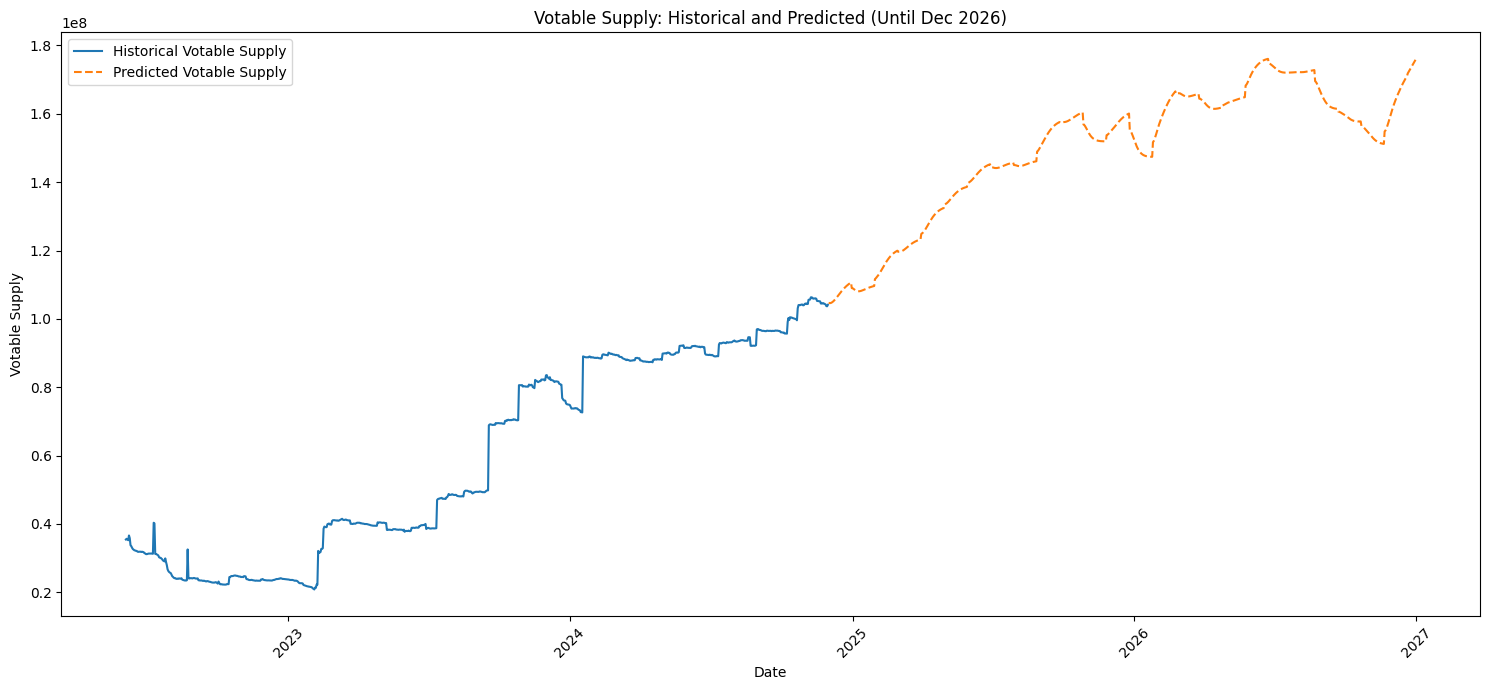


Predictions saved to ../../Dataset/Future_Votable_Supply/FVS_Daywise_Data_Demo1.csv


In [3]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import tensorflow as tf
import random
import os
import yaml

# Load config settings
with open('config.yaml', 'r') as config_file:
    config = yaml.load(config_file, Loader=yaml.FullLoader)

# Set random seeds for reproducibility
def set_seeds(seed=42):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    tf.keras.utils.set_random_seed(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
    os.environ['TF_NUM_INTRAOP_THREADS'] = '1'
    os.environ['TF_NUM_INTEROP_THREADS'] = '1'

def load_and_prepare_data(price_file, cs_file, vs_file, future_cs_file):
    price_df = pd.read_csv(price_file)
    cs_df = pd.read_csv(cs_file)
    vs_df = pd.read_csv(vs_file)
    future_cs_df = pd.read_csv(future_cs_file)
    
    price_df['Date'] = pd.to_datetime(price_df['Date'], format=config['date_format']['price_data'])
    cs_df['Date'] = pd.to_datetime(cs_df['Date'], format=config['date_format']['circulating_votable_data'])
    vs_df['Date'] = pd.to_datetime(vs_df['Date'], format=config['date_format']['circulating_votable_data'])
    future_cs_df['Date'] = pd.to_datetime(future_cs_df['Date'], format=config['date_format']['future_circulating_supply_data'])
    
    price_df.columns = ['Date', 'Price']
    merged_df = pd.merge(vs_df, cs_df, on='Date', how='inner')
    merged_df = pd.merge(merged_df, price_df, on='Date', how='inner')
    
    merged_df = merged_df.sort_values('Date')
    future_cs_df = future_cs_df.sort_values('Date')
    
    return merged_df, future_cs_df

def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length, 0])
    return np.array(X), np.array(y)

def build_lstm_model(input_shape):
    model = Sequential([
        LSTM(config['prediction_settings']['lstm_units_1'], return_sequences=True, input_shape=input_shape),
        Dropout(config['prediction_settings']['dropout_rate']),
        LSTM(config['prediction_settings']['lstm_units_2'], return_sequences=False),
        Dropout(config['prediction_settings']['dropout_rate']),
        Dense(config['prediction_settings']['dense_units_1']),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=config['prediction_settings']['model_learning_rate']), loss='mse')
    return model

def predict_until_target_date(price_file, cs_file, vs_file, future_cs_file, target_date, batch_size=30, sequence_length=60, seed=42):
    set_seeds(seed)
    df, future_cs_df = load_and_prepare_data(price_file, cs_file, vs_file, future_cs_file)
    feature_columns = ['Votable Supply', 'Circulating Supply', 'Price']
    
    # Scaling Method
    if config['scaling_method'] == 'minmax':
        scaler = MinMaxScaler()
    else:
        from sklearn.preprocessing import StandardScaler
        scaler = StandardScaler()
    
    scaled_data = scaler.fit_transform(df[feature_columns])
    target_date = pd.to_datetime(target_date)
    current_date = df['Date'].iloc[-1]
    all_predictions = []
    all_dates = []
    
    while current_date < target_date:
        X, y = create_sequences(scaled_data, sequence_length)
        set_seeds(seed)
        model = build_lstm_model((sequence_length, X.shape[2]))
        model.fit(X, y, epochs=config['prediction_settings']['epochs'], batch_size=32, verbose=0)
        
        current_sequence = scaled_data[-sequence_length:].reshape(1, sequence_length, len(feature_columns))
        batch_predictions = []
        batch_dates = []
        
        for _ in range(batch_size):
            if current_date >= target_date:
                break
            current_date += timedelta(days=1)
            batch_dates.append(current_date)
            future_cs = future_cs_df[future_cs_df['Date'] == current_date]['Circulating Supply'].iloc[0]
            next_pred = float(model.predict(current_sequence, verbose=0)[0])
            batch_predictions.append(next_pred)
            last_step = current_sequence[0, -1:, :].copy()
            last_step[0, 0] = next_pred
            temp_data = df[feature_columns].iloc[-1:].copy()
            temp_data['Circulating Supply'] = future_cs
            scaled_future_cs = scaler.transform(temp_data)[0, 1]
            last_step[0, 1] = scaled_future_cs
            current_sequence = np.concatenate([
                current_sequence[:, 1:, :],
                last_step.reshape(1, 1, len(feature_columns))
            ], axis=1)
        
        prediction_matrix = np.zeros((len(batch_predictions), len(feature_columns)))
        prediction_matrix[:, 0] = batch_predictions
        future_cs_values = [future_cs_df[future_cs_df['Date'] == date]['Circulating Supply'].iloc[0] for date in batch_dates]
        prediction_matrix[:, 1] = future_cs_values
        prediction_matrix[:, 2] = df[feature_columns].iloc[-1]['Price']
        unscaled_predictions = scaler.inverse_transform(prediction_matrix)[:, 0]
        all_predictions.extend(unscaled_predictions)
        all_dates.extend(batch_dates)
        new_data = np.zeros((len(batch_predictions), len(feature_columns)))
        new_data[:, 0] = unscaled_predictions
        new_data[:, 1] = future_cs_values
        new_data[:, 2] = df[feature_columns].iloc[-1]['Price']
        scaled_new_data = scaler.transform(new_data)
        scaled_data = np.vstack([scaled_data, scaled_new_data])
    
    predictions_df = pd.DataFrame({
        'Date': all_dates,
        'Predicted_Votable_Supply': all_predictions
    })
    
    # Plotting
    plt.figure(figsize=config['plot_settings']['figure_size'])
    plt.plot(df['Date'], df['Votable Supply'], label='Historical Votable Supply')
    plt.plot(predictions_df['Date'], predictions_df['Predicted_Votable_Supply'], label='Predicted Votable Supply', linestyle='--')
    plt.title(config['plot_settings']['title'])
    plt.xlabel(config['plot_settings']['xlabel'])
    plt.ylabel(config['plot_settings']['ylabel'])
    plt.legend()
    plt.xticks(rotation=config['plot_settings']['xticks_rotation'])
    plt.tight_layout() if config['plot_settings']['tight_layout'] else None
    plt.show()
    
    return predictions_df

if __name__ == "__main__":
    set_seeds(config['random_seeds']['seed'])
    predictions = predict_until_target_date(
        config['dataset_paths']['price_data'],
        config['dataset_paths']['circulating_supply_data'],
        config['dataset_paths']['votable_supply_data'],
        config['dataset_paths']['future_circulating_supply_data'],
        config['prediction_settings']['target_date'],
        seed=config['random_seeds']['seed']
    )
    predictions.to_csv(config['dataset_paths']['output_predictions'], index=False)
    print(f"\nPredictions saved to {config['dataset_paths']['output_predictions']}")
